In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df = df.drop(columns=['Name', 'Ticket'])

df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_test = df_test.drop(columns=['Name', 'Ticket'])
#df_y_test = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# Extract the first letter(s) of the Cabin column
df['Cabin'] = df['Cabin'].fillna('Unknown')  # Fill missing cabins with 'Unknown'
df['Cabin'] = df['Cabin'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))  # Extract only letters (e.g., 'C', 'FE')
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

df_test['Cabin'] = df_test['Cabin'].fillna('Unknown')  # Fill missing cabins with 'Unknown'
df_test['Cabin'] = df_test['Cabin'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))  # Extract only letters (e.g., 'C', 'FE')
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['Embarked'].fillna(df_test['Embarked'].mode()[0], inplace=True)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)

features = df.columns
print(df.head())
print("No. of training data",len(df))
print("No. of testing data",len(df_test))
print(Counter(df['Survived']))

   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    male  22.0      1      0   7.2500   
1            2         1       1  female  38.0      1      0  71.2833   
2            3         1       3  female  26.0      0      0   7.9250   
3            4         1       1  female  35.0      1      0  53.1000   
4            5         0       3    male  35.0      0      0   8.0500   

     Cabin Embarked  
0  Unknown        S  
1        C        C  
2  Unknown        S  
3        C        S  
4  Unknown        S  
No. of training data 891
No. of testing data 418
Counter({0: 549, 1: 342})


In [4]:
pre_x = df.drop('Survived', axis = 1)
#pre_y_test = df_y_test.drop('PassengerId', axis = 1)
dm_y = df['Survived']
dm_x = pd.get_dummies(pre_x, columns=['Cabin', 'Embarked', 'Sex'])
dm_x_test = pd.get_dummies(df_test, columns=['Cabin', 'Embarked', 'Sex'])

# Get the list of columns in training and test datasets
train_columns = dm_x.columns
test_columns = dm_x_test.columns

# Align columns: Add missing columns to each dataset with zeros and drop mismatched columns
for col in train_columns:
    if col not in test_columns:
        print(col)
        dm_x_test[col] = 0  # Add missing columns to test set

for col in test_columns:
    if col not in train_columns:
        print(col)
        dm_x[col] = 0  # Add missing columns to training set

# Ensure the order of columns is the same
dm_x = dm_x[sorted(dm_x.columns)]
dm_x_test = dm_x_test[sorted(dm_x_test.columns)]
train_columns = dm_x.columns
test_columns = dm_x_test.columns

#print(dm_x)
x_train = dm_x.to_numpy() 
y_train = dm_y.to_numpy()
x_test = dm_x_test.to_numpy()
#y_test = pre_y_test.to_numpy()
print(len(train_columns))
print(len(test_columns))
print(train_columns)
print(test_columns)

Cabin_T
Cabin_EE
29
29
Index(['Age', 'Cabin_A', 'Cabin_B', 'Cabin_BB', 'Cabin_BBB', 'Cabin_BBBB',
       'Cabin_C', 'Cabin_CC', 'Cabin_CCC', 'Cabin_D', 'Cabin_DD', 'Cabin_E',
       'Cabin_EE', 'Cabin_F', 'Cabin_FE', 'Cabin_FG', 'Cabin_G', 'Cabin_T',
       'Cabin_Unknown', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare',
       'Parch', 'PassengerId', 'Pclass', 'Sex_female', 'Sex_male', 'SibSp'],
      dtype='object')
Index(['Age', 'Cabin_A', 'Cabin_B', 'Cabin_BB', 'Cabin_BBB', 'Cabin_BBBB',
       'Cabin_C', 'Cabin_CC', 'Cabin_CCC', 'Cabin_D', 'Cabin_DD', 'Cabin_E',
       'Cabin_EE', 'Cabin_F', 'Cabin_FE', 'Cabin_FG', 'Cabin_G', 'Cabin_T',
       'Cabin_Unknown', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare',
       'Parch', 'PassengerId', 'Pclass', 'Sex_female', 'Sex_male', 'SibSp'],
      dtype='object')


In [5]:
#Scaling
sc = MinMaxScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42, shuffle=True)

In [7]:
#Neural Network
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Build the neural network model
model = Sequential([
    Dense(128, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),  # Hidden Layer 1
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden Layer 1
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden Layer 2
    BatchNormalization(),
    Dropout(0.1),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),  # Hidden Layer 2
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')  # Output Layer (binary classification)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4924 - loss: 1.2442 - val_accuracy: 0.4778 - val_loss: 0.8885
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4812 - loss: 1.1696 - val_accuracy: 0.5778 - val_loss: 0.8780
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5532 - loss: 1.0166 - val_accuracy: 0.5667 - val_loss: 0.8681
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5908 - loss: 1.0064 - val_accuracy: 0.6000 - val_loss: 0.8623
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5664 - loss: 1.0000 - val_accuracy: 0.6444 - val_loss: 0.8594
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6044 - loss: 0.9374 - val_accuracy: 0.6667 - val_loss: 0.8569
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6009 - loss: 0.9085 - val_accuracy: 0.6667 - val_loss: 0.8526
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6488 - loss: 0.8977 - val_accuracy: 0.6778 - val_loss

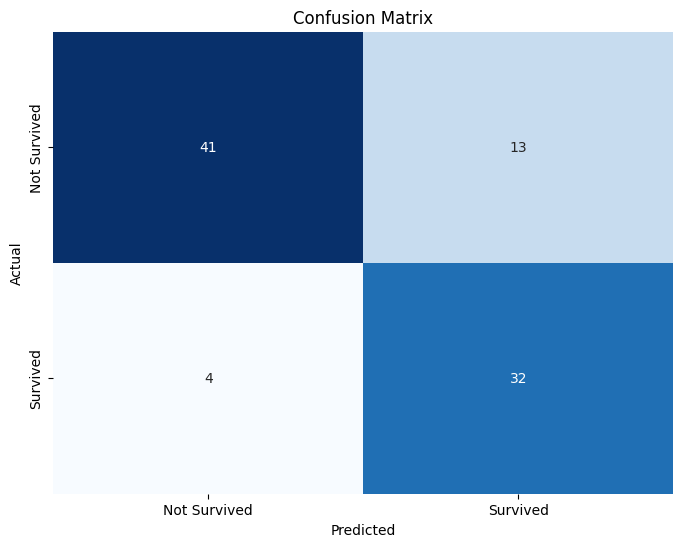

In [8]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    epochs=30, batch_size=60, class_weight=class_weight_dict, callbacks=[early_stopping])
#res_model.fit(x_train, y_train, epochs=100, batch_size=32, 
              #validation_data=(x_val, y_val), class_weight=class_weight_dict, verbose=2)

# Make predictions on validation data
y_val_pred = model.predict(x_val).flatten()  # Flatten to 1D array

# Convert probabilities to binary predictions
y_val_pred_binary = np.where(y_val_pred >= 0.55, 1, 0)

# Make predictions on test data
y_pred = model.predict(x_test).flatten()
y_pred_binary = np.where(y_pred >= 0.55, 1, 0)

# Create DataFrame with predictions
predictions_df = pd.DataFrame({
    'PassengerId': dm_x_test['PassengerId'],  # Assuming 'PassengerId' column is available
    'Survived': y_pred_binary
})

# Save predictions to CSV
predictions_df.to_csv('/kaggle/working/titanic_predictions.csv', index=False)
print("Predictions saved to titanic_predictions.csv")

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred_binary)
print("Prediction Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_binary)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

# Labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Survived', 'Survived'])
ax.yaxis.set_ticklabels(['Not Survived', 'Survived'])

# Show the plot
plt.show()

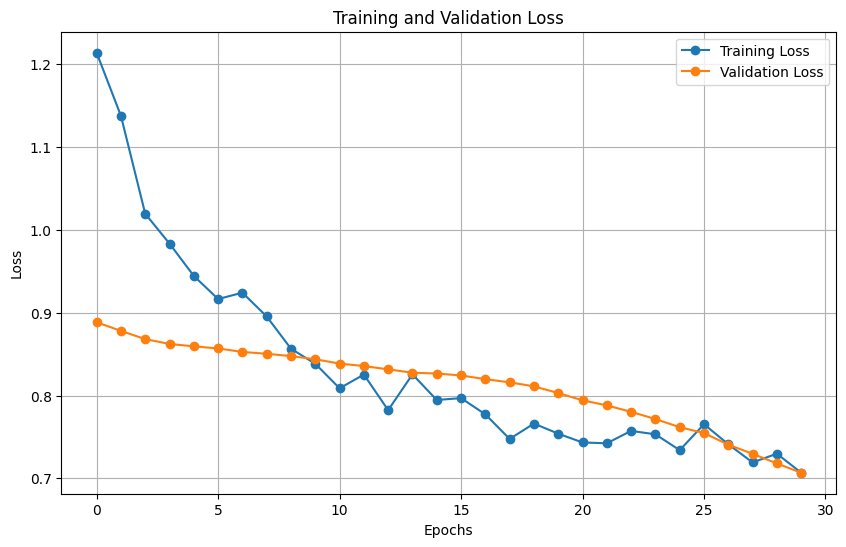

[1.2140249013900757, 1.137810230255127, 1.0195486545562744, 0.9834375977516174, 0.944456160068512, 0.9165202379226685, 0.9241896867752075, 0.8954746723175049, 0.8564991354942322, 0.8383740782737732, 0.8087053298950195, 0.8253010511398315, 0.7823341488838196, 0.825549304485321, 0.7946022152900696, 0.7968374490737915, 0.7772416472434998, 0.7475331425666809, 0.7661005854606628, 0.7539128661155701, 0.7432987689971924, 0.742276132106781, 0.7572692036628723, 0.7531174421310425, 0.7339840531349182, 0.7653231620788574, 0.7411225438117981, 0.7191482186317444, 0.7297226190567017, 0.7067564725875854]
[0.888495147228241, 0.8780256509780884, 0.8681282997131348, 0.8622618913650513, 0.8593719601631165, 0.8568524718284607, 0.8526338338851929, 0.850382387638092, 0.8475937843322754, 0.8437515497207642, 0.8385692834854126, 0.8355839252471924, 0.8315863609313965, 0.8275483846664429, 0.826542317867279, 0.8242295384407043, 0.8197267055511475, 0.8159165382385254, 0.8110624551773071, 0.8029782772064209, 0.794

In [9]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
print(history.history['loss'])
print(history.history['val_loss'])

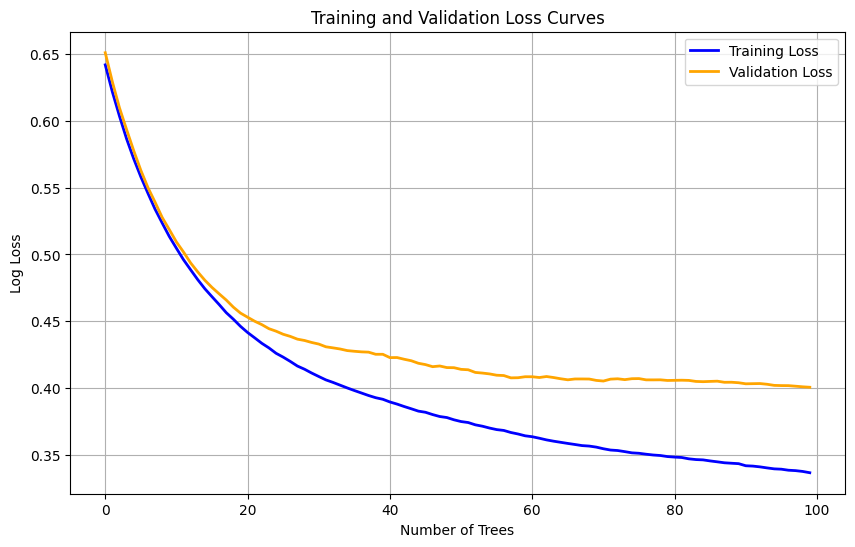

Predictions saved to titanic_predictions.csv
Prediction Accuracy: 0.8111111111111111


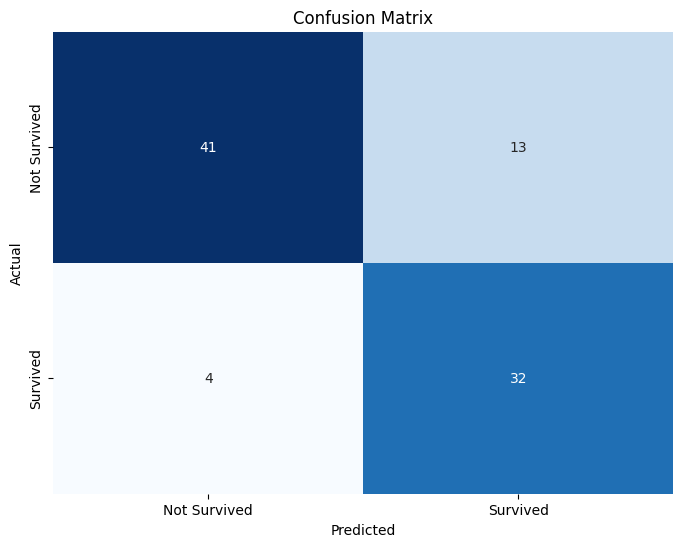

[0.6417717519939052, 0.6215385026274992, 0.603379660066374, 0.5863851664504847, 0.571508399549227, 0.5580065499231113, 0.5456692777218606, 0.53380506288959, 0.523464383528245, 0.5133964033030591, 0.5045833655550992, 0.4959818748512131, 0.488465587418251, 0.481074077390736, 0.47426762808294015, 0.46833073915574924, 0.4625083694233091, 0.4564188905881612, 0.45151755080369826, 0.44619376239322955, 0.4415796190387732, 0.4375737148198564, 0.4334914713540049, 0.4300450685104324, 0.4260332092458401, 0.4231470243189595, 0.4199388275287109, 0.41648628254876513, 0.4141039389027761, 0.41126671175809226, 0.4086680158771603, 0.4061302674192205, 0.4042469921592458, 0.40218009252647247, 0.4001101372176634, 0.39817428188024456, 0.39631485518689796, 0.394446786026149, 0.3928042183299343, 0.39163495324709124, 0.38961344100540374, 0.3880347382616724, 0.38621027555524007, 0.3845254587194378, 0.38275964704860177, 0.38190408857921293, 0.38018257425469887, 0.3787267205909961, 0.3779687507025353, 0.3762738630

In [10]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# Create an instance of the Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Fit the model to the training data
model.fit(x_train, y_train)

# Make predictions on the validation data
#y_val_pred = model.predict_proba(x_val)[:, 1]  # Get probability for the positive class

# Convert probabilities to binary predictions using the 0.55 threshold
#y_val_pred_binary = np.where(y_val_pred >= 0.5, 1, 0)

# Track the loss at each iteration
training_loss = []
validation_loss = []

# Calculate loss after each boosting iteration
for y_train_pred, y_val_pred in zip(model.staged_predict_proba(x_train), 
                                    model.staged_predict_proba(x_val)):
    # Compute log loss for training and validation
    training_loss.append(log_loss(y_train, y_train_pred))
    validation_loss.append(log_loss(y_val, y_val_pred))

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(validation_loss, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on the test data
y_pred = model.predict_proba(x_test)[:, 1]

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Create a DataFrame with PassengerId and Survived columns
predictions_df = pd.DataFrame({
    'PassengerId': dm_x_test['PassengerId'],  # Assuming dm_x_test has 'PassengerId' column
    'Survived': y_pred_binary
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('/kaggle/working/titanic_predictions.csv', index=False)

print("Predictions saved to titanic_predictions.csv")

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred_binary)
print("Prediction Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_binary)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

# Labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Survived', 'Survived'])
ax.yaxis.set_ticklabels(['Not Survived', 'Survived'])

# Show the plot
plt.show()
print(training_loss)
print(validation_loss)


Predictions saved to titanic_predictions.csv
Prediction Accuracy: 0.8333333333333334


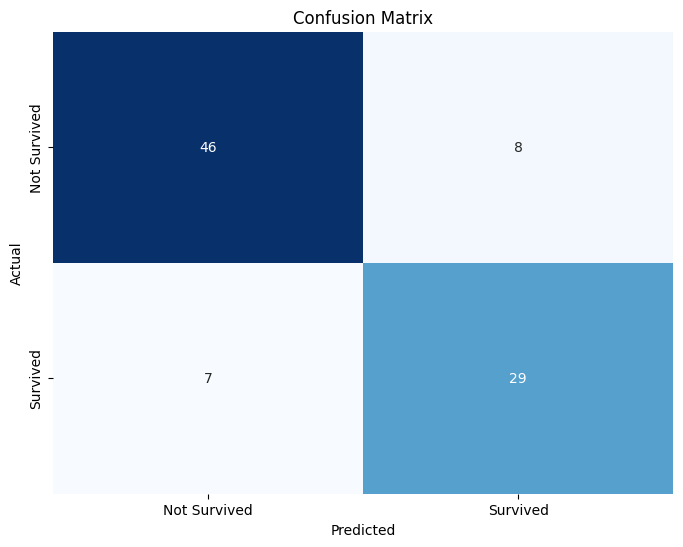

In [11]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Create an instance of the Random Forest model
model = RandomForestClassifier(n_estimators=80, random_state=42)

# Fit the model to the training data
model.fit(x_train, y_train)

y_val_pred = model.predict(x_val)

y_val_pred_binary = np.where(y_val_pred >= 0.55, 1, 0)

# Make predictions on the test data
y_pred = model.predict(x_test)

# Convert continuous predictions to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred >= 0.55, 1, 0)

# Assuming you have a 'PassengerId' column in your test dataset or you can match it from the original dataset
# Create a DataFrame with PassengerId and Survived columns
predictions_df = pd.DataFrame({
    'PassengerId': dm_x_test['PassengerId'],  # Assuming dm_x_test has 'PassengerId' column
    'Survived': y_pred_binary
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('/kaggle/working/titanic_predictions.csv', index=False)

print("Predictions saved to titanic_predictions.csv")
# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred_binary)
print("Prediction Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_binary)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

# Labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Survived', 'Survived'])
ax.yaxis.set_ticklabels(['Not Survived', 'Survived'])

# Show the plot
plt.show()

Prediction Accuracy: 0.8333333333333334


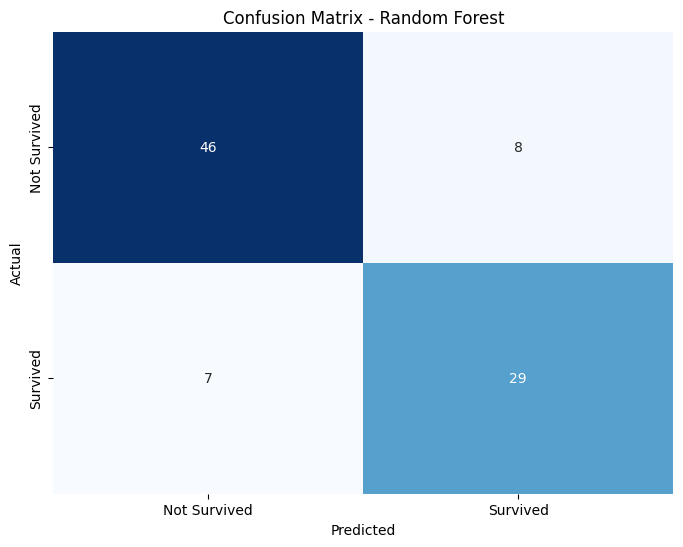

Feature Importance:
          Feature  Importance
12       Cabin_EE    0.000000
5      Cabin_BBBB    0.000047
14       Cabin_FE    0.000342
17        Cabin_T    0.000418
4       Cabin_BBB    0.000482
15       Cabin_FG    0.000566
16        Cabin_G    0.000928
10       Cabin_DD    0.000948
8       Cabin_CCC    0.001096
3        Cabin_BB    0.002078
13        Cabin_F    0.002327
1         Cabin_A    0.002603
7        Cabin_CC    0.004877
9         Cabin_D    0.004936
2         Cabin_B    0.005654
6         Cabin_C    0.006524
20     Embarked_Q    0.007096
11        Cabin_E    0.010136
19     Embarked_C    0.011709
21     Embarked_S    0.013106
18  Cabin_Unknown    0.031205
23          Parch    0.032556
28          SibSp    0.044439
25         Pclass    0.055428
27       Sex_male    0.115589
26     Sex_female    0.135997
0             Age    0.159502
22           Fare    0.174264
24    PassengerId    0.175146


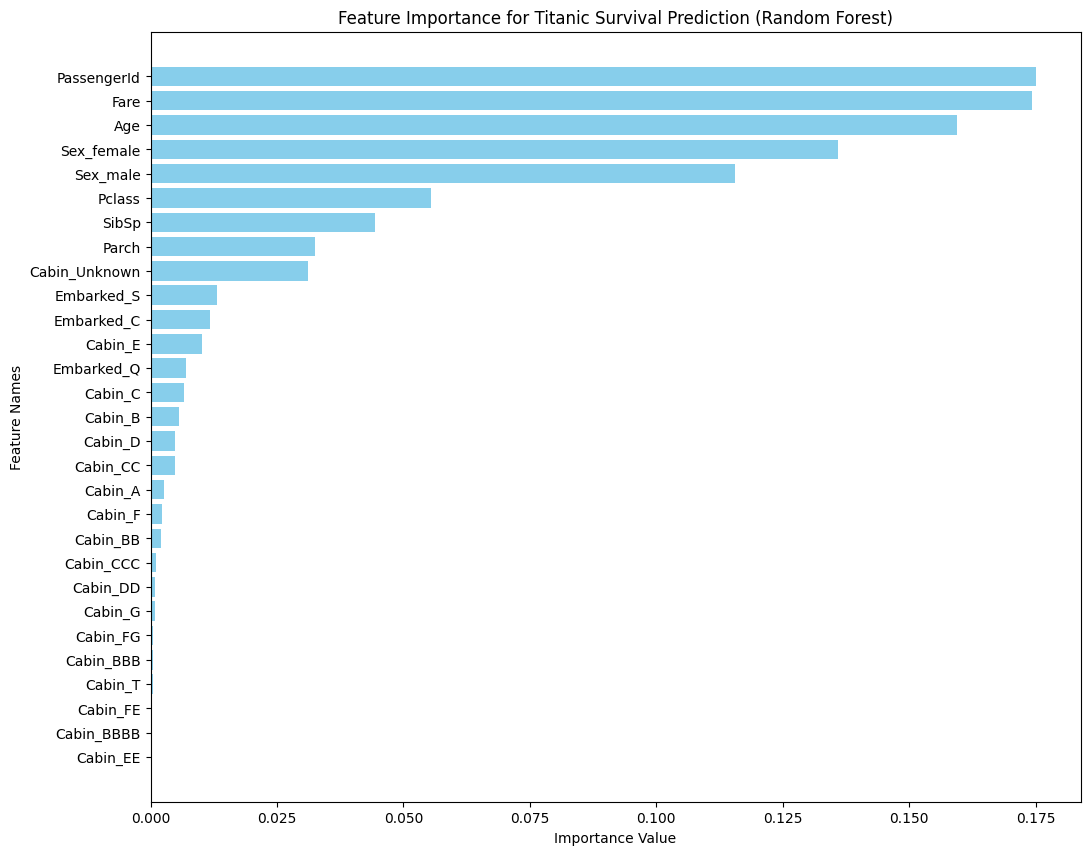

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create an instance of the Random Forest model
model = RandomForestClassifier(n_estimators=80, random_state=42)

# Fit the model to the training data
model.fit(x_train, y_train)

# Make predictions on the validation data
y_val_pred = model.predict(x_val)

y_val_pred_binary = np.where(y_val_pred >= 0.55, 1, 0)

# Make predictions on the test data
y_pred = model.predict(x_test)

# Convert continuous predictions to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred >= 0.55, 1, 0)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred_binary)
print("Prediction Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_binary)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Random Forest')
ax.xaxis.set_ticklabels(['Not Survived', 'Survived'])
ax.yaxis.set_ticklabels(['Not Survived', 'Survived'])
plt.show()

# Feature Importance using RandomForestClassifier's built-in feature importances
feature_importance = pd.DataFrame({
    'Feature': train_columns,  # Column names from the OHE encoding
    'Importance': model.feature_importances_
})

# Sort by the importance value
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)  # Sort ascending for better horizontal plot

# Print feature importance
print("Feature Importance:")
print(feature_importance)

# Visualize feature importance using a horizontal histogram plot
plt.figure(figsize=(12, 10))  # Adjust figure size for better readability
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.title('Feature Importance for Titanic Survival Prediction (Random Forest)')
plt.xlabel('Importance Value')
plt.ylabel('Feature Names')
plt.show()


Top 15 Important Features:
          Feature  Importance
24    PassengerId    0.175146
22           Fare    0.174264
0             Age    0.159502
26     Sex_female    0.135997
27       Sex_male    0.115589
25         Pclass    0.055428
28          SibSp    0.044439
23          Parch    0.032556
18  Cabin_Unknown    0.031205
21     Embarked_S    0.013106
Selected Top 15 Features: ['PassengerId' 'Fare' 'Age' 'Sex_female' 'Sex_male' 'Pclass' 'SibSp'
 'Parch' 'Cabin_Unknown' 'Embarked_S']
10
Prediction Accuracy with Top 10 Features: 0.8156424581005587


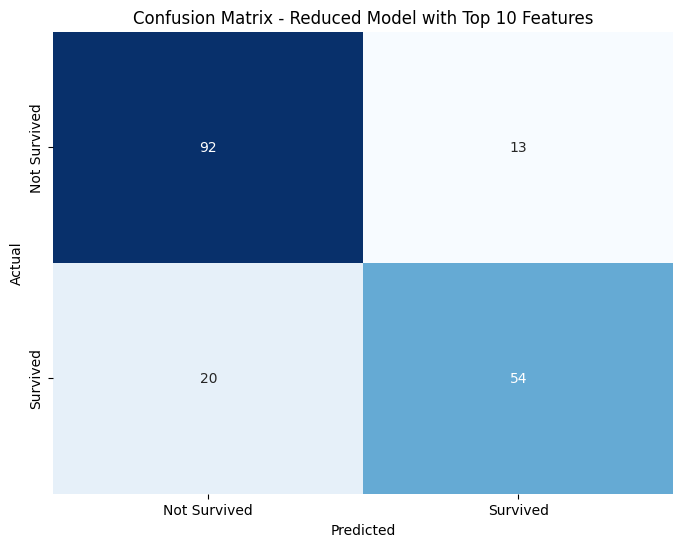

In [13]:
# Sort by the importance value and select the top 10 features
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
print("Top 15 Important Features:")
print(top_10_features)

# Create a new training and test set using only the top 10 features
top_10_feature_names = top_10_features['Feature'].values
print(f"Selected Top 15 Features: {top_10_feature_names}")

# Create a reduced training and test set with the top 10 features
x_train_reduced = dm_x[top_10_feature_names].to_numpy()
x_test_reduced = dm_x_test[top_10_feature_names].to_numpy()
y_train = dm_y.to_numpy()


x_train, x_val, y_train, y_val = train_test_split(x_train_reduced, y_train, test_size=0.2, random_state=42, shuffle=True)
print(len(x_train[0]))
# Train a new model on the reduced dataset
# Create an instance of the Random Forest model
reduced_model = RandomForestClassifier(n_estimators=80, random_state=42)

reduced_model.fit(x_train, y_train)

y_val_pred = reduced_model.predict(x_val)

y_val_pred_binary = np.where(y_val_pred >= 0.55, 1, 0)

# Make predictions on the reduced test set
y_pred_reduced = reduced_model.predict(x_test_reduced)

# Convert continuous predictions to binary predictions (0 or 1)
y_pred_binary_reduced = np.where(y_pred_reduced >= 0.55, 1, 0)

# Calculate accuracy of the reduced model
accuracy_reduced = accuracy_score(y_val, y_val_pred_binary)
print("Prediction Accuracy with Top 10 Features:", accuracy_reduced)

# Calculate confusion matrix for the reduced model
conf_matrix_reduced = confusion_matrix(y_val, y_val_pred_binary)

# Visualize the confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_reduced, annot=True, fmt='g', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Reduced Model with Top 10 Features')
ax.xaxis.set_ticklabels(['Not Survived', 'Survived'])
ax.yaxis.set_ticklabels(['Not Survived', 'Survived'])
plt.show()

In [14]:
# Assuming 'PassengerId' is present in the test set
passenger_ids = df_test['PassengerId'].values

# Save the results in a CSV file with 2 columns: PassengerId and Survived
predictions_df_reduced = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_pred_binary_reduced
})

# Save the DataFrame to a CSV file
predictions_df_reduced.to_csv('/kaggle/working/titanic_predictions_reduced.csv', index=False)

print("Predictions saved to titanic_predictions_reduced.csv")

Predictions saved to titanic_predictions_reduced.csv


In [15]:
print(classification_report(y_val, y_val_pred_binary, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.82      0.88      0.85       105
    Survived       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

